In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set_theme(style="darkgrid")
%matplotlib inline

# Load model predictions
df = pd.read_csv('../data/processed/AAPL_stock_data_cleaned.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Reattach ARIMA and Prophet predictions (assumes you've saved or still have them)
# If not, you should re-run models from 03 and copy the prediction code here
# Here's the dummy structure:
# df['ARIMA_Pred'] = ...
# df['Prophet_Pred'] = ...


In [2]:
def evaluate(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return round(rmse, 2), round(mae, 2), round(mape, 2)


In [5]:
# Ensure Close column is numeric
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Drop rows with missing Close values
df.dropna(subset=['Close'], inplace=True)


In [6]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model_arima = ARIMA(df['Close'], order=(1, 1, 1))
arima_result = model_arima.fit()

# Predict and add to df
df['ARIMA_Pred'] = arima_result.predict(start=1, end=len(df)-1, typ='levels')


C:\Users\Mayur\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Mayur\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Mayur\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Mayur\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

In [9]:
print(df.columns)


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'ARIMA_Pred'], dtype='object')


In [10]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = df[['Close']].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

# Initialize and fit Prophet model
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(prophet_df)

# Forecast only over the current known date range
future = model_prophet.make_future_dataframe(periods=0)
forecast = model_prophet.predict(future)

# ✅ Add Prophet predictions aligned with df index
df['Prophet_Pred'] = forecast.loc[forecast['ds'] <= df.index[-1], 'yhat'].values


20:18:50 - cmdstanpy - INFO - Chain [1] start processing
20:18:51 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
print(df[['Close', 'ARIMA_Pred', 'Prophet_Pred']].tail())


                 Close  ARIMA_Pred  Prophet_Pred
Date                                            
2024-12-23  254.655716  253.779309    233.191642
2024-12-24  257.578674  254.584596    232.884174
2024-12-26  258.396667  257.478286    232.262884
2024-12-27  254.974930  258.323544    231.996573
2024-12-30  251.593094  255.004958    231.243598


In [12]:
# Clean rows with missing predictions
df_eval = df.dropna(subset=['ARIMA_Pred', 'Prophet_Pred'])

# Evaluate ARIMA
arima_rmse, arima_mae, arima_mape = evaluate(df_eval['Close'], df_eval['ARIMA_Pred'])

# Evaluate Prophet
prophet_rmse, prophet_mae, prophet_mape = evaluate(df_eval['Close'], df_eval['Prophet_Pred'])

# Build a summary DataFrame
eval_df = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet'],
    'RMSE': [arima_rmse, prophet_rmse],
    'MAE': [arima_mae, prophet_mae],
    'MAPE (%)': [arima_mape, prophet_mape]
})

print(eval_df)


     Model  RMSE   MAE  MAPE (%)
0    ARIMA  2.29  1.57      1.36
1  Prophet  7.99  6.23      6.30


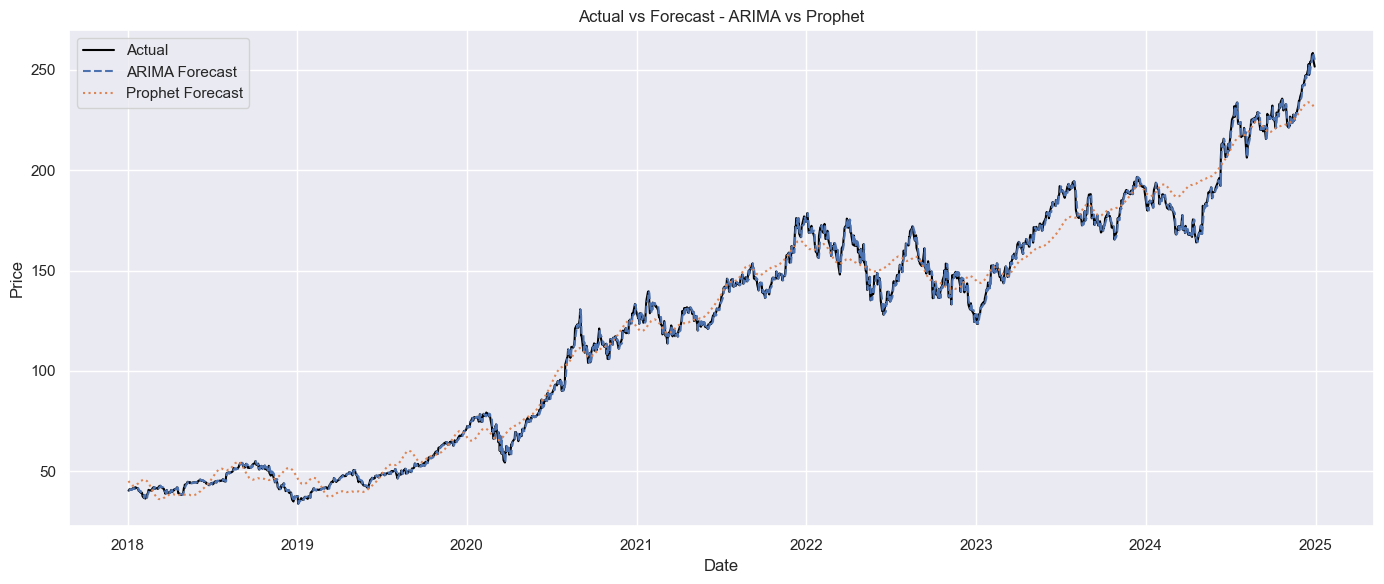

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(df_eval['Close'], label='Actual', color='black')
plt.plot(df_eval['ARIMA_Pred'], label='ARIMA Forecast', linestyle='--')
plt.plot(df_eval['Prophet_Pred'], label='Prophet Forecast', linestyle=':')
plt.title('Actual vs Forecast - ARIMA vs Prophet')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_eval['ARIMA_Residual'] = df_eval['Close'] - df_eval['ARIMA_Pred']
df_eval['Prophet_Residual'] = df_eval['Close'] - df_eval['Prophet_Pred']

plt.figure(figsize=(14, 6))
sns.histplot(df_eval['ARIMA_Residual'], kde=True, color='blue', label='ARIMA Residuals')
sns.histplot(df_eval['Prophet_Residual'], kde=True, color='green', label='Prophet Residuals')
plt.title('Residual Distribution Comparison')
plt.xlabel('Error')
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
from IPython.display import Markdown

Markdown(f"""
### ✅ Model Evaluation Summary

- **ARIMA**
  - RMSE: {arima_rmse}
  - MAE: {arima_mae}
  - MAPE: {arima_mape:.2f}%

- **Prophet**
  - RMSE: {prophet_rmse}
  - MAE: {prophet_mae}
  - MAPE: {prophet_mape:.2f}%

**Conclusion:** Based on the metrics above, {"ARIMA" if arima_rmse < prophet_rmse else "Prophet"} performed better on this dataset. 
Consider {"Prophet" if prophet_mape < arima_mape else "ARIMA"} if interpretability or seasonality is more important.
""")



### ✅ Model Evaluation Summary

- **ARIMA**
  - RMSE: 2.29
  - MAE: 1.57
  - MAPE: 1.36%

- **Prophet**
  - RMSE: 7.99
  - MAE: 6.23
  - MAPE: 6.30%

**Conclusion:** Based on the metrics above, ARIMA performed better on this dataset. 
Consider ARIMA if interpretability or seasonality is more important.


In [15]:
eval_df.to_csv('../reports/model_comparison.csv', index=False)
